In [248]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [119]:
# Load data
train = pd.read_csv("C:/Users/harper.yang/Kaggle/Bank Customer Churn/train.csv")
test = pd.read_csv("C:/Users/harper.yang/Kaggle/Bank Customer Churn//test.csv")

In [120]:
# Custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df['AgeGroup'] = df['Age'] // 10 * 10
        df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
        df['QualityOfBalance'] = pd.cut(df['Balance'], bins=[-1, 100, 1000, 10000, 50000, 300000], labels=['VeryLow', 'Low', 'Medium', 'High', 'Highest'])
        df['QualityOfBalance'].replace(['VeryLow', 'Low', 'Medium', 'High', 'Highest'], [0, 1, 2, 3, 4], inplace=True)
        df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
        df['CreditScoreTier'] = pd.cut(df['CreditScore'], bins=[0, 650, 750, 850], labels=['Low', 'Medium', 'High'])
        df['CreditScoreTier'].replace(['Low', 'Medium', 'High'], [0, 1, 2], inplace=True)
        df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
        df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts']
        df['Customer_Loyalty_Status'] = df['Tenure'].apply(lambda x: 0 if x < 2 else 1)
        return df

In [123]:
# Define categorical and numerical columns
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']  

In [125]:
# Pipelines for preprocessing steps, num_cols will still be the same after mixmax scaler
num_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())    
])

cat_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

In [127]:
# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols),
       #('text', text_pipeline, text_col),
        #('poly', poly_pipeline, poly_cols)
    ],
    remainder='passthrough'  # Keeps other columns
)

# Main pipeline with the step to drop the specified columns
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),
    #('text_concat', TextConcatenation()),  # Concatenate text features
    ('preprocessor', preprocessor),
    #('drop_columns', DropColumns(columns_to_drop=['CusId_Sur']))  # Drop specific columns, multicollinearity might exist with the vectorized features
    ('model', LogisticRegression(max_iter=100000))
])

In [129]:
# Prepare training and testing data
X = train.drop(columns=['Exited','id','CustomerId','Surname'])
y = train['Exited']
X_test = test

In [131]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [133]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'model__C': np.logspace(-4, 4, 10),
    'model__solver': ['lbfgs'],
    'model__class_weight': ['balanced']
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall') 
#false negatives need to be reduced here

In [135]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureEngineering()),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Balance',
                                                                          'EstimatedSalary']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder...
                                                                          'NumOfProducts',
                                                                          'HasCrCard',
                                                                          'IsActiveMember'])])),
                                       ('model',
                                        LogisticRegression(max_iter=100000))]),
             param_grid={'model__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'model__class_weight': ['balanced'],
                         'model__solver': ['lbfgs']},
             scoring='recall')

In [224]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# After fitting the model
y_probs = best_model.predict_proba(X_val)[:, 1]
threshold = 0.5  # Example threshold, adjust as needed, lower then recall is better
y_pred_adjusted = (y_probs > threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_adjusted)

# Generate classification report
class_report = classification_report(y_val, y_pred_adjusted)

In [226]:
# Display results
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[31313  7820]
 [ 2113  8265]]


In [228]:
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     39133
           1       0.51      0.80      0.62     10378

    accuracy                           0.80     49511
   macro avg       0.73      0.80      0.74     49511
weighted avg       0.85      0.80      0.81     49511



In [246]:
accuracy = accuracy_score(y_val, y_pred_adjusted)
f1 = f1_score(y_val, y_pred_adjusted, average="macro")
recall = recall_score(y_val, y_pred_adjusted, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%"," Recall:", round(recall, 2), "F1:", round(f1, 2))

Accuracy: 80.0%  Recall: 0.8 F1: 0.74


In [ ]:
#with open("Results/metrics.txt", "w") as outfile:
#    outfile.write(f"\nAccuracy = {accuracy.round(2)}, F1 Score = {f1.round(2)}.")

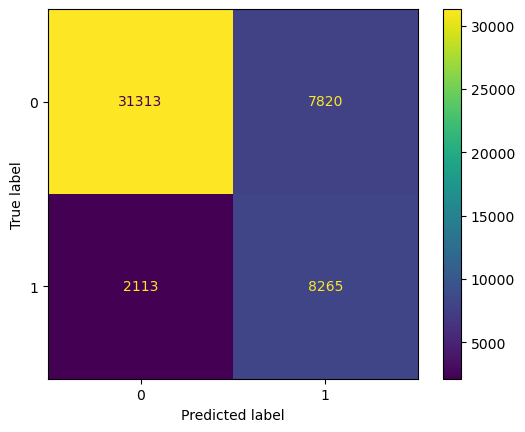

In [256]:
class_labels = best_model.classes_
cm = confusion_matrix(y_val, y_pred_adjusted,labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot()
#plt.savefig("Results/model_results.png", dpi=120)